In [19]:
import os

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential

import cv2 as cv
import matplotlib.pyplot as plt

### Reading data

In [85]:
def read_dataset(path, size=128):
    ds = tf.keras.utils.image_dataset_from_directory(
        path,
        label_mode='categorical',
        shuffle=True,
        seed=42,
        image_size=(size, size),
    )
    
    X, y = zip(*ds)
    X = np.concatenate(X)
    y = np.concatenate(y)
    
    return X, y

In [86]:
train_X, train_y = read_dataset('data/train/')
test_X, test_y = read_dataset('data/test/')
labels = sorted(os.listdir('data/train'))

Found 10019 files belonging to 10 classes.
Found 500 files belonging to 10 classes.


### Gray

In [4]:
def cvt_to_gray(images):
    gray_images = []
    for rgb_image in images:
        gray_image = cv.cvtColor(rgb_image, cv.COLOR_RGB2GRAY)
        gray_images.append(gray_image)
    gray_images = np.array(gray_images)
    gray_images = gray_images[..., np.newaxis]
    return gray_images

In [133]:
gray_train_X = cvt_to_gray(train_X)
gray_test_X = cvt_to_gray(test_X)
gray_train_X.shape, gray_test_X.shape

((10019, 64, 64, 1), (353, 64, 64, 1))

In [171]:
gray_train_X = np.abs(gray_train_X)
gray_test_X = np.abs(gray_test_X)

### Gradients

In [90]:
PREWITT_KERNEL_X = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
PREWITT_KERNEL_Y = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])

In [91]:
def get_gradients(rgb_image):
    gray_image = cv.cvtColor(rgb_image, cv.COLOR_RGB2GRAY) / 256
    
    sobel_x = cv.Sobel(gray_image, cv.CV_64F,1,0,ksize=3)
    sobel_y = cv.Sobel(gray_image, cv.CV_64F,0,1,ksize=3)
    sobel_xy = cv.Sobel(gray_image, cv.CV_64F,1,1,ksize=3)
    sobel_amp = np.sqrt(np.power(sobel_x, 2), np.power(sobel_y, 2))
    
    prewitt_x = cv.filter2D(gray_image, -1, PREWITT_KERNEL_X)
    prewitt_y = cv.filter2D(gray_image, -1, PREWITT_KERNEL_Y)
    prewitt_amp = np.sqrt(np.power(prewitt_x, 2), np.power(prewitt_y, 2))
    
    return [sobel_x, sobel_y, sobel_xy, sobel_amp]

In [92]:
def cvt_to_gradients(images):
    grad_images = []
    for rgb_image in images:
        gradients = get_gradients(rgb_image)
        grad_images.append(gradients)
    grad_images = np.array(grad_images)
    grad_images = np.transpose(grad_images, (0, 2, 3, 1))
    return grad_images

In [93]:
grad_train_X = cvt_to_gradients(train_X)
grad_test_X = cvt_to_gradients(test_X)
grad_train_X.shape, grad_test_X.shape

bin_grad_train_X = np.abs(grad_train_X)
bin_grad_test_X = np.abs(grad_test_X)

In [94]:
np.max(grad_train_X), np.min(grad_train_X)

(3.8845125772058964, -3.770690521225333)

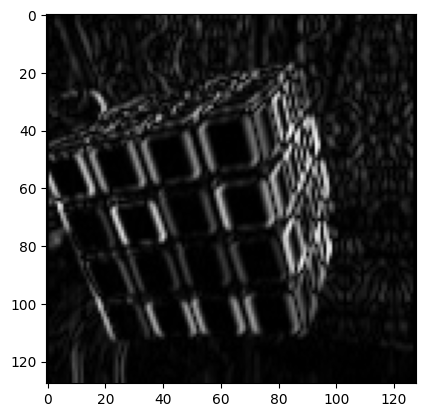

In [96]:
plt.imshow(grad_train_X[402, ..., 3], 'gray')

In [97]:
model = Sequential([
    layers.Input(shape=(None, None, 4)),
    layers.Resizing(128, 128),
    # layers.RandomFlip('horizontal'),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax'),
])

In [98]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_10 (Resizing)      (None, 128, 128, 4)       0         
                                                                 
 conv2d_40 (Conv2D)          (None, 126, 126, 32)      1184      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 28, 28, 128)     

In [99]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [100]:
history = model.fit(bin_grad_train_X, train_y, validation_data=(bin_grad_test_X, test_y), epochs=40, batch_size=64)

Epoch 1/40
157/157 [==============================] - 9s 43ms/step - loss: 1.9687 - accuracy: 0.2285 - val_loss: 1.6668 - val_accuracy: 0.3340
Epoch 2/40
157/157 [==============================] - 6s 37ms/step - loss: 1.1130 - accuracy: 0.5803 - val_loss: 1.7844 - val_accuracy: 0.4500
Epoch 3/40
157/157 [==============================] - 6s 37ms/step - loss: 0.6378 - accuracy: 0.7631 - val_loss: 1.1649 - val_accuracy: 0.6160
Epoch 4/40
157/157 [==============================] - 6s 37ms/step - loss: 0.3675 - accuracy: 0.8750 - val_loss: 1.0930 - val_accuracy: 0.6840
Epoch 5/40
157/157 [==============================] - 6s 37ms/step - loss: 0.2164 - accuracy: 0.9300 - val_loss: 1.2869 - val_accuracy: 0.7120
Epoch 6/40
157/157 [==============================] - 6s 37ms/step - loss: 0.1519 - accuracy: 0.9508 - val_loss: 1.4683 - val_accuracy: 0.6940
Epoch 7/40
157/157 [==============================] - 6s 37ms/step - loss: 0.0923 - accuracy: 0.9727 - val_loss: 1.4113 - val_accuracy: 0.7400

16/16 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

           0       0.57      0.56      0.57        50
           1       0.66      0.78      0.72        50
           2       0.58      0.58      0.58        50
           3       0.82      0.90      0.86        50
           4       0.58      0.66      0.62        50
           5       0.93      1.00      0.96        50
           6       0.88      0.86      0.87        50
           7       1.00      0.96      0.98        50
           8       0.69      0.54      0.61        50
           9       0.95      0.76      0.84        50

    accuracy                           0.76       500
   macro avg       0.77      0.76      0.76       500
weighted avg       0.77      0.76      0.76       500



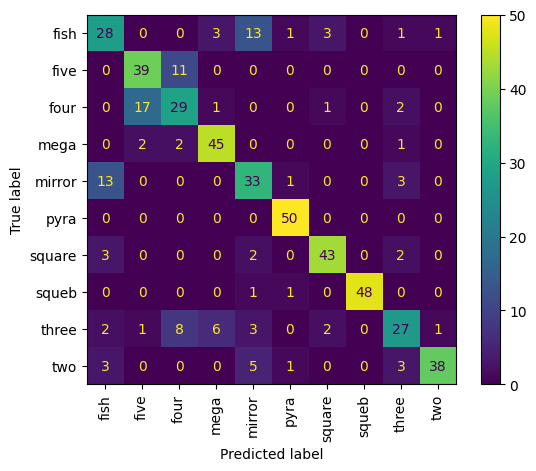

In [101]:
predictions = model.predict(bin_grad_test_X)
true_classes = np.argmax(test_y, axis=1)
predicted_classes = np.argmax(predictions, axis=1)

report = classification_report(true_classes, predicted_classes)
cm = confusion_matrix(true_classes, predicted_classes)

print(report)
ConfusionMatrixDisplay.from_predictions(
    true_classes, 
    predicted_classes, 
    display_labels=labels, 
    xticks_rotation='vertical',
);